In [ ]:
#라이브러리 설치 및 불러오기

!pip install -q pytorch-lightning torch torchvision
!pip install -q matplotlib
!pip install scikit-learn seaborn matplotlib

In [ ]:


# 확인
import pytorch_lightning as pl
import torch
import torchvision
print("PyTorch:", torch.__version__)
print("Lightning:", pl.__version__)

PyTorch: 2.7.1+cu128
Lightning: 2.5.2


In [ ]:
#구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/data')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 경로 지정
train_path = r"F:\archive\New_Plant_Diseases_Dataset(Augmented)\train"
val_path   = r"F:\archive\New_Plant_Diseases_Dataset(Augmented)\valid"


# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# 데이터셋 로딩
train_data = datasets.ImageFolder(root=train_path, transform=transform)
val_data   = datasets.ImageFolder(root=val_path, transform=transform)


# 데이터로더 설정
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=16)


# 클래스 확인
print(f"클래스 수: {len(train_data.classes)}")
print(f"클래스 이름: {train_data.classes}")

클래스 수: 38
클래스 이름: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', '

In [ ]:
#모델 정의

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassF1Score

class PlantDiseaseClassifier(pl.LightningModule):
    """
    배치 정규화와 학습률 스케줄러가 추가된 식물 질병 분류 모델입니다.
    """
    def __init__(self, num_classes, learning_rate=1e-3):
        super().__init__()
        # save_hyperparameters()를 호출하면 learning_rate와 같은 값들이 self.hparams에 저장되어 편리합니다.
        self.save_hyperparameters()

        # --- 모델 구조 정의 ---
        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # 배치 정규화 레이어 추가

        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # 배치 정규화 레이어 추가

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier (Fully Connected Layers)
        self.fc1 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.4) # 드롭아웃 비율을 조금 높여 과적합 방지 강화
        )
        self.fc2 = nn.Linear(128, num_classes)

        # --- 손실 함수 및 평가 지표 ---
        self.loss_fn = nn.CrossEntropyLoss()
        # F1 Score 계산을 위한 객체 (device에 맞게 자동으로 이동됩니다)
        self.f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

    def forward(self, x):
        """ 모델의 순전파 로직을 정의합니다. """
        # Conv -> BatchNorm -> ReLU -> Pool 순서로 적용합니다.
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x) # fc1 내부에 ReLU와 Dropout이 포함되어 있습니다.
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        """ 학습 단계(step)를 정의합니다. """
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()

        # self.log를 사용해 TensorBoard 등에 기록합니다.
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """ 검증 단계(step)를 정의합니다. """
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        f1_score = self.f1(y_hat.argmax(dim=1), y) # F1 스코어 계산

        # 검증 결과를 기록합니다.
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        self.log("val_f1", f1_score, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        """ 옵티마이저와 학습률 스케줄러를 설정합니다. """
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-4)

        # 학습률 스케줄러 설정: val_loss가 5 에포크 동안 개선되지 않으면 학습률을 0.1배로 줄입니다.
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=5,
            # verbose=True # Removed verbose argument
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss", # val_loss를 기준으로 스케줄러 동작
            },
        }

In [ ]:
# 모델 트레이닝

import pytorch_lightning as pl
# from your_model_file import PlantDiseaseClassifier # 모델 클래스를 불러오는 부분
# from your_data_file import train_loader, val_loader # 데이터 로더를 불러오는 부분

# 숫자는 아무거나 상관 X, 보통 42를 많이 씁니다.
pl.seed_everything(42, workers=True)

#모델을 생성과 학습 시작.
model = PlantDiseaseClassifier(num_classes=len(train_loader.dataset.classes))

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    log_every_n_steps=10,
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor="val_f1", mode="max", save_top_k=1,
            filename="best-model-{epoch:02d}-{val_f1:.2f}_second_gen"
        ),
        pl.callbacks.EarlyStopping(
            monitor="val_f1", mode="max", patience=5, verbose=True
        )
    ]
)

trainer.fit(model, train_loader, val_loader)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | conv1   | Conv2d            | 896    | train
1 | bn1     | BatchNorm2d       | 64     | train
2 | conv2   | Conv2d            | 18.5 K | train
3 | bn2     | BatchNorm2d       | 128    | train
4 | pool    | MaxPool2d         | 0      | train
5 | gap     | AdaptiveAvgPool2d | 0      | train
6 | fc1     | Sequential        | 8.3 K  | train
7 | fc2     | Linear            | 4.9 K  | train
8 | loss_fn | CrossEntropyLoss  | 0      | train
9 | f1      | MulticlassF1Score | 0      | train
------------------------------------------------------
32.8 K    Trainable params
0         Non-trainable params
32.8 K    Total params
0.131     Total estimated model params size (MB)
13        Modules in train mode
0         Modul

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved. New best score: 0.251


Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.093 >= min_delta = 0.0. New best score: 0.344


Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.047 >= min_delta = 0.0. New best score: 0.391


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.104 >= min_delta = 0.0. New best score: 0.495


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.034 >= min_delta = 0.0. New best score: 0.529


Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.001 >= min_delta = 0.0. New best score: 0.530


Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.037 >= min_delta = 0.0. New best score: 0.567


Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.016 >= min_delta = 0.0. New best score: 0.583


Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.020 >= min_delta = 0.0. New best score: 0.604


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.031 >= min_delta = 0.0. New best score: 0.634


Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.018 >= min_delta = 0.0. New best score: 0.652


Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.013 >= min_delta = 0.0. New best score: 0.664


Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.019 >= min_delta = 0.0. New best score: 0.684


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.006 >= min_delta = 0.0. New best score: 0.690


Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.044 >= min_delta = 0.0. New best score: 0.734


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_f1 improved by 0.032 >= min_delta = 0.0. New best score: 0.766


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Monitored metric val_f1 did not improve in the last 5 records. Best score: 0.766. Signaling Trainer to stop.


In [ ]:
import torch
from tqdm.auto import tqdm

# 예측값과 실제 레이블을 저장할 리스트 초기화
all_preds = []
all_labels = []

print("테스트 데이터셋 예측 및 실제 레이블 수집 중...")

# 모델을 평가 모드로 설정
model.eval()

# 그래디언트 계산 비활성화
with torch.no_grad():
    # 테스트 데이터로더를 순회하며 예측값 수집
    for inputs, labels in tqdm(test_loader, desc="Collecting predictions"):
        # 데이터를 모델과 동일한 디바이스로 이동 (GPU 사용 시)
        inputs = inputs.to(model.device)
        labels = labels.to(model.device)

        # 모델 예측 수행
        outputs = model(inputs)
        # 가장 높은 확률을 가지는 클래스 인덱스 선택
        _, predicted = torch.max(outputs.data, 1)

        # 예측값과 실제 레이블을 리스트에 추가 (CPU로 이동하여 저장)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("예측 및 실제 레이블 수집 완료.")

# 결과를 PyTorch Tensor로 변환 (필요에 따라)
all_preds = torch.tensor(all_preds)
all_labels = torch.tensor(all_labels)

# 수집된 데이터 크기 확인
print(f"수집된 예측값 수: {len(all_preds)}")
print(f"수집된 실제 레이블 수: {len(all_labels)}")

테스트 데이터셋 예측 및 실제 레이블 수집 중...


예측 및 실제 레이블 수집 완료.
수집된 예측값 수: 33
수집된 실제 레이블 수: 33


✅ 전체 정확도 (Accuracy): 0.0303

📊 분류 보고서 (Classification Report)
                                        precision    recall  f1-score   support

                    Apple___Apple_scab       1.00      0.03      0.06        33
              Apple___Cedar_apple_rust       0.00      0.00      0.00         0
                       Apple___healthy       0.00      0.00      0.00         0
           Corn_(maize)___Common_rust_       0.00      0.00      0.00         0
                       Grape___healthy       0.00      0.00      0.00         0
                 Potato___Early_blight       0.00      0.00      0.00         0
                      Potato___healthy       0.00      0.00      0.00         0
                 Tomato___Early_blight       0.00      0.00      0.00         0
Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.00      0.00      0.00         0
                      Tomato___healthy       0.00      0.00      0.00         0

                              accuracy                  

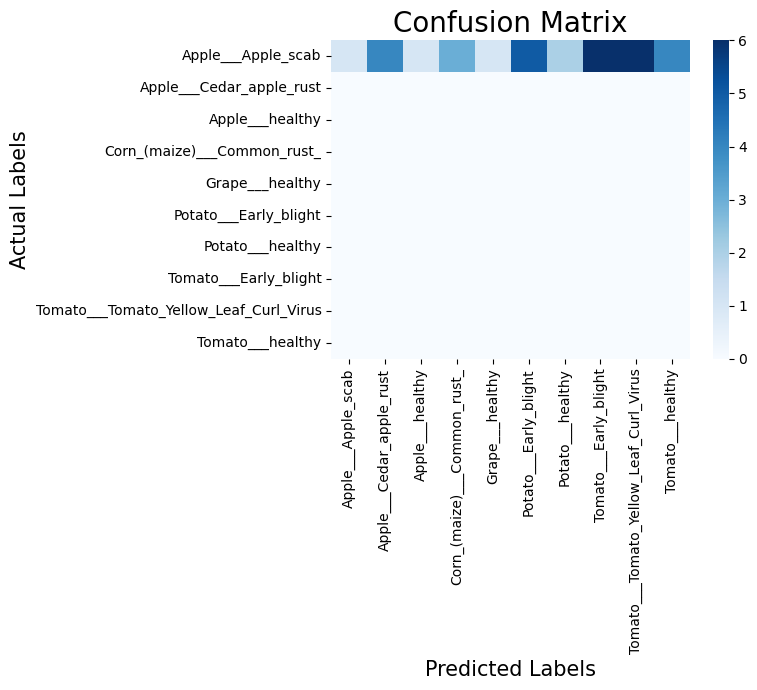

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# PyTorch Tensor를 NumPy 배열로 변환
all_preds_np = all_preds.cpu().numpy()
all_labels_np = all_labels.cpu().numpy()

# 제공해주신 38개의 클래스 이름 리스트
class_names = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy',
    'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight',
    'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy',
    'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy',
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight',
    'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]

# 실제 데이터에 존재하는 고유한 레이블 가져오기
unique_labels = np.unique(np.concatenate((all_labels_np, all_preds_np)))

# 고유한 레이블에 해당하는 클래스 이름만 필터링
filtered_class_names = [class_names[i] for i in unique_labels if i < len(class_names)]

# 1. 정확도 (Accuracy) 계산
accuracy = accuracy_score(all_labels_np, all_preds_np)
print(f"✅ 전체 정확도 (Accuracy): {accuracy:.4f}\n")

# 2. 분류 보고서 (Classification Report) 출력
# 실제 존재하는 레이블과 필터링된 클래스 이름을 사용하여 보고서 생성
print("📊 분류 보고서 (Classification Report)")
report = classification_report(all_labels_np, all_preds_np, labels=unique_labels, target_names=filtered_class_names, zero_division=0)
print(report)

# 3. 혼동 행렬 (Confusion Matrix) 생성 및 시각화
print("🔀 혼동 행렬 (Confusion Matrix)")
cm = confusion_matrix(all_labels_np, all_preds_np, labels=unique_labels) # 실제 존재하는 레이블을 사용하여 혼동 행렬 생성

# 클래스가 너무 많아 숫자(annot)를 표시하면 가독성이 떨어지므로 색상으로만 표현합니다.
# 이미지 크기를 키워 클래스 이름이 잘 보이도록 조정합니다.
plt.figure(figsize=(len(filtered_class_names)*0.8, len(filtered_class_names)*0.7)) # 혼동 행렬 크기 동적 조정
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=filtered_class_names, yticklabels=filtered_class_names)
plt.title('Confusion Matrix', fontsize=20)
plt.ylabel('Actual Labels', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=15)
plt.tight_layout() # 레이아웃을 자동으로 조정하여 이름이 잘리지 않도록 함
plt.savefig('confusion_matrix_filtered.png') # 파일 이름 변경

print("\n혼동 행렬을 'confusion_matrix_filtered.png' 파일로 저장했습니다.")